This is a spam classifier built from scratch and based on Bayes Theorem:
$P(A | B) = \frac{P(B | A) P(A)}{P(B)}$

* P(A) and P(B) are the marginal probabilities of observing A (spam) and B (content)
* P(A | B) is the conditional probability of A given B (probability a given email is spam)
* P(B | A) is the conditional probability of B given A (probability of a word given the set of all words in spam emails)

It states that for two discrete events, A and B, if we know the conditional probability of B given A and the probability of A, we can compute the conditional probability of A given B.

In other words, the posterior probability of A given B can be calculated by multiplying the likelyhood by the prior probability and dividing by the evidence term.

Posterior Probability = $\frac{Likelihood \ * \ Prior \ Probability}{Evidence}$

The theorem is used to update probabilities in light of new knowledge (the evidence).

We'll use a family of linear classifiers based off of Bayes Theorem called Naive Bayes Classifiers, which work well for small datasets:

$P(y \ | \ x_1,\ ...\ ,\ x_n) = \frac{P(x_1,\ ...\ , \ x_n\ |\ y) P(y)}{P(x_1,\ ...\ ,\ x_n)}$, where y is a class variable and $x_1, \ ... \ ,x_n$ is a dependent feature vector.

Hence, our predicted output is the following:

$\hat y = arg \ \underset{\rm y}{\rm max} \ P(y) \ \Pi_{i=1}^n \ P(x_i \ | \ y)$

To make predictions using Naive Bayes, we'll calculate probabilities of the instance belonging to each class and select the class value with the highest probability.

Naive Bayes makes two assumptions about the data:
1. Samples are independent from eachother and identically distributed (drawn from a similar distribution)
2. Conditional independence of features (likelihood of the samples can be directly estimated from the training data)

**Run the code below to import dependencies**

In [1]:
try:
    import pandas as pd # data processing module, used here to read csv, name and replace columns, and get dataframe values
    import matplotlib.pyplot as plt # used to create visualizations
    from sklearn.model_selection import train_test_split # split input data into training and testing with a oneliner
    import statistics as stats # for mean, median, and standard deviation
except ImportError:
    print('Use "pip install (distribution name)" to get the missing distribution.') 

**Load the data corpus (Source: *Kaggle* "SMS Spam Collection Dataset")**

Each line of the dataset is stored in a dataframe object using the pandas read_csv function. The dataframe also has 3 unnamed, useless columns, and we only need columns at index 0 and 1, so we use the keyword argument usecols. We need latin-1 encoding because not all the characters can be handled by utf-8, seen as some characters appear as �.

The imported data corpus has column names "v1" and "v2" by default, where "v1" is the label "ham" or "spam" and "v2" is the raw text of a single email. We rename "v1" to "label" and the individual labels "ham" and "spam" to 0 and 1, respectively. We change "v2" to "text" with the pandas .columns attribute.

In [2]:
try:
    spam_data = pd.read_csv('spam.csv', usecols=[0,1], encoding="latin-1")
    spam_data.columns = ['label', 'text']
    spam_data['label'] = spam_data['label'].replace(['ham', 'spam'], [0, 1])
    data = spam_data.values # the pandas dataframe is stored in the "data" variable.
except FileNotFoundError:
    print("Make sure you downloaded the spam.csv file to the same path as wherever you're running this, or change the path.")

**Data Analysis on the corpus**

In [3]:
spam_data.head() # show the format of our dataframe

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
spam_data.groupby('label').describe() # show spam and non-spam counts, unique counts, and top message with frequency

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

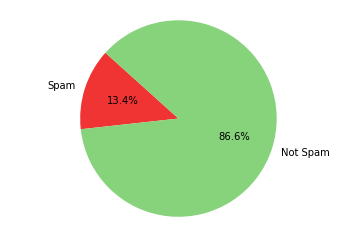

In [5]:
not_spam = spam_data.groupby('label').size()[0]
spam = spam_data.groupby('label').size()[1] # use .size so you don't have to hard code numbers
tot = spam_data.count(numeric_only=True)[0] # get total number messages

labels = 'Spam', 'Not Spam' # physical labels to display
sizes = spam/tot, not_spam/tot # [number_spam/total, number_not_spam/total], from above info
colors = '#F03434', '#87D37C' # fancy red and green
 
# pie chart with above info, show sizes as %, crispy angle
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', startangle=138) 
 
plt.axis('equal') # flatten image
plt.show() # display it

The dataset is quite imbalanced (86.6% is spam and only 13.4% is non-spam). Therefore, a model that guesses "spam" for every email will have 86.6% accuracy, which seems high, but is total garbage, since it's just a reflection of the underlying class distribution, seen above. This is known as the "accuracy paradox."

In [6]:
# create 3 lists, one all spam, one all not spam, and one with both
all_ = list(pd.Series(spam_data['text'])) # all split message texts 
dist_all = [len(_.split(' ')) for _ in all_] # list of word lengths of all split message texts

all_spam = list(pd.Series(spam_data[spam_data['label'] == 0]['text']))
dist_s = [len(_.split(' ')) for _ in all_spam]

all_not_spam = list(pd.Series(spam_data[spam_data['label'] == 1]['text']))
dist_ns = [len(_.split(' ')) for _ in all_not_spam]

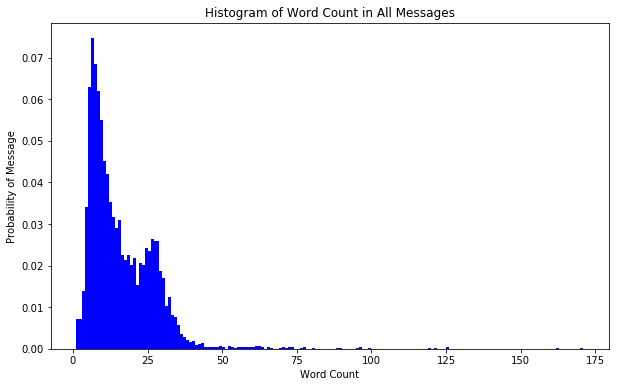

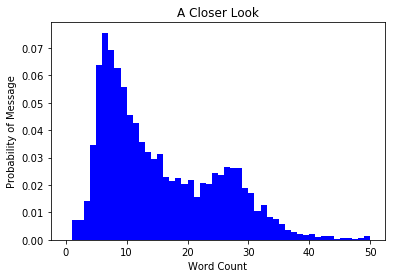

Some Summary Statistics
Min 	1 
Mean 	15.60678391959799 
Median 	12.00 
StDev 	11.422465115303629 
Max 	171


In [7]:
plt.figure(figsize=(10, 6)) # tried different x,y values in inches until it looks nice

plt.hist(dist_all, bins=170, color='b', normed=True) # blue. divide to 170 bins.

plt.xlabel('Word Count')
plt.ylabel('Probability of Message')
plt.title('Histogram of Word Count in All Messages')
plt.show()

plt.hist(dist_all, bins=50, range=[0,50], color='b', normed=True) # blue. divide to 170 bins.
plt.xlabel('Word Count')
plt.ylabel('Probability of Message')
plt.title('A Closer Look')
plt.show()

print('Some Summary Statistics')
print(f'Min \t{min(dist_all)} \nMean \t{stats.mean(dist_all)} \nMedian \t{stats.median(dist_all):.2f} \nStDev \t{stats.stdev(dist_all)} \nMax \t{max(dist_all)}')

The dataset is strongly skewed right. The mean is significantly greater than the median, since the skew pulls it to the right. The distribution is unimodal, with a range of 170 (maximum of 171 - minimum of 1).

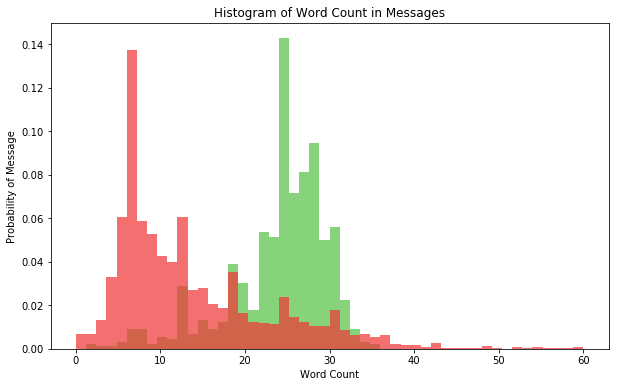

Summary Statistics

	Non-Spam	Spam
Min 	2 		1 
Mean 	23.89 		14.32 
Med 	25.00 		11.00 
StDev 	5.83 		11.54 
Max 	35 		171 



In [8]:
plt.figure(figsize=(10,6))

plt.hist(dist_ns, bins=50, range=[0,60], color='#87D37C', normed=True, alpha=1, label='not spam') # green
plt.hist(dist_s, bins=50, range=[0, 60], color='#F03434', normed=True, alpha=.7, label='spam') # red

plt.xlabel('Word Count')
plt.ylabel('Probability of Message')
plt.title('Histogram of Word Count in Messages')
plt.show()
print('Summary Statistics\n')
print('\tNon-Spam\tSpam')
print(f'Min \t{min(dist_ns)} \t\t{min(dist_s)} \nMean \t{stats.mean(dist_ns):.2f} \t\t{stats.mean(dist_s):.2f} \nMed \t{stats.median(dist_ns):.2f} \t\t{stats.median(dist_s):.2f} \nStDev \t{stats.stdev(dist_ns):.2f} \t\t{stats.stdev(dist_s):.2f} \nMax \t{max(dist_ns)} \t\t{max(dist_s)} \n')

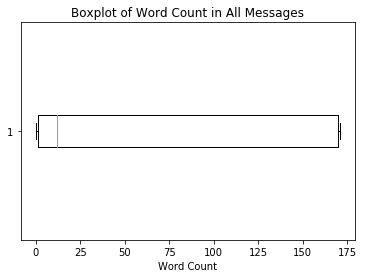

In [9]:
box_data = ((max(dist_all)-min(dist_all), stats.median(dist_all), max(dist_all), min(dist_all), 0))
plt.boxplot(box_data, 0, 'rs', 0)
plt.xlabel('Word Count')
plt.title('Boxplot of Word Count in All Messages')
plt.show()

**Create bag-of-words Naive Bayes Classifier**

Rather than just use functions (procedure-oriented programming), we create a class called naive_bayes_classifier that we can train and test later (object oriented programming).

Every function within this class (or method) has an additional initial parameter, called self. 

In [10]:
class naive_bayes_classifier:
    
    def __init__(self, data, split=0.7):
        """Constructor method called when the naive_bayes_classifier class is constructed; all attributes are declared here.
        Args: 
            data (:obj:dataframe): The pandas dataframe object in the format [<(int) label> <(str) raw text>]
            split (float, optional): The train/test split ratio
        """
        # split into training (train the model) and testing (measure accuracy) data with recommended 70/30 split 
        self.train_data, self.test_data = train_test_split(data, train_size=split)

        # convert into unigrams / bag-of-words (two ways of looking at it)
        self.train_data = [[item[0], item[1].split(' ')] for item in self.train_data]
        self.test_data = [[item[0], item[1].split(' ')] for item in self.test_data]
        
        # count unique words in training data
        flattened = [word for message in self.train_data for word in message[1]]
        self.num_unique_words = len(set(flattened))

        # initialize dictionaries
        self.train_pos = {}
        self.train_neg = {}

        # counters
        self.pos_word_count = 0
        self.neg_word_count = 0
        self.spam_count = 0

        # prior probabilities
        self.pA = 0
        self.pNotA = 0
    
    def train(self):
        """Count number of spam emails, spam words, non spam words, and calculate P(A) and P(Not A)."""
        for item in self.train_data: # for item in corpus
            label = item[0] # label is 0 or 1 for "ham" or "spam"
            text = item[1] # text is the raw email text
            if label == 1: # if the email is spam ...
                self.spam_count += 1 # increase the spam count by 1
            for word in text: # for each word in the email text
                if label == 1: # if the email is spam ...
                    self.train_pos[word] = self.train_pos.get(word, 0) + 1 # dict of spam words, increase frequency of each repeated spam word
                    self.pos_word_count += 1 # count the number of spam words total
                else: # if the email is not spam ...
                    self.train_neg[word] = self.train_neg.get(word, 0) + 1 # dict of non spam words, increase frequency of each repeated non spam word
                    self.neg_word_count += 1 # count the number of non spam words total
                    
        self.pA = self.spam_count/float(len(self.train_data)) # P(A) = probability of spam, spam mail over total mail
        self.pNotA = 1.0 - self.pA # P(Not A) = 1 - P(A) by complement rule
        
    def classify(self, text):
        """Classify a test-set email as spam or not spam
        Args:
            text (str): The raw text of a single email
        return: (int) 0 or 1 based on whether the email is spam
        """
        # take product of the P(B_word | A_iterator) value for every word in the email 
        pB_given_A = self.pA * self.conditional(text,1)
        pB_given_notA = self.pNotA * self.conditional(text, 0)
        if pB_given_A > pB_given_notA: # if is_spam > not_spam, classify as spam
            return 1
        else: # if P(not spam) > P(spam), classify as not spam 
            return 0
            
    def conditional(self, text, label):
        """Bag-of-words model used to calculate conditional probabilities
        Args:
            text (str): The raw text of a single email
            label (int): The label of a single email (0 or 1)
        return: (int) Conditional probability with laplacian smoothing
        """
        result = 1.0
        for word in text:
            if label == 1:
                # product of former conditional probability and percentage of times word shows up in spam emails
                # +1 for "laplacian / add one smoothing" so the frequency of no word in a corpus but not a specific email is 0
                # ... which would make the probability of the whole email 0
                result *= (self.train_pos.get(word,0) + 1) / float(self.pos_word_count + 1 * self.num_unique_words)
            else:
                # product of former conditional probability and percentage of times word shows up in non spam emails
                result *= (self.train_neg.get(word,0) + 1) / float(self.neg_word_count + 1 * self.num_unique_words)
        return result
    
    def test_accuracy(self):
        """Measure the accuracy of the model by testing on new and unseen data"""        
        results = []
        for test in self.test_data: # for every email in the testing set
            label = test[0] # label of 0 or 1 is the first column
            text = test[1] # raw text is the second column
            ruling = self.classify(text) # greatest probability is the ruling
            if ruling == label: # if the estimated value equals actual value (we're right)
                results.append(1) # add one to the results
            else: # if the estimated value != actual value (we're wrong)
                results.append(0) # don't add to the results
        
        print(f"{100.0*sum(results)/float(len(results)):.2f}% accuracy with {len(results)} test datapoints.")

In [11]:
bag_of_words_model = naive_bayes_classifier(data) # load the spam data in our model

Here, we call methods of the object bag_of_words_model.

In [12]:
bag_of_words_model.train() # train the model with our custom function

In [13]:
bag_of_words_model.test_accuracy() # test the model, accuracy changes since split changes, typically around 96 to 97%

96.47% accuracy with 1672 test datapoints.


**Conclusion**

Our model achieved around 97% accuracy. Gmail is supposedly 99.9% accurate. This is not a direct comparison, since different datasets are used. 

State-of-the-art spam filters achieve extremely high accuracy through several means: 
- Use Deep Learning (more complex functions through Neural Nets) with Big Data (terabytes of email data vs 208 KB)
- More "features" are used, including:
    1. source of the message
    2. software used to send the message
    3. content of the message
    4. recipient engagement
    5. personal preferences
    6. postmaster tools
    
How you could potentially improve this model:
- Term Frequency-Inverse Document Frequency to reflect the importance of words in the corpus
- Find the optimal parameters of the model, including split size, dictionary size, dataset size, and threshold

**Works Consulted**

[Wolfram - Bayes Theorem](http://mathworld.wolfram.com/BayesTheorem.html)

[Scikit Learn - Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html)

[Udacity - LaTeX](http://data-blog.udacity.com/posts/2016/10/latex-primer/)

[Gmail - Spam Filtering](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html)